# Sprint 機械学習フロー

**Sprintの目的**

- 機械学習の実践的な流れを知る
- 高い汎化性能を持つモデルを完成させる

**どのように学ぶか**

- 丁寧な検証が行える状態にした上で、他者の解法を参考に汎化性能の高いモデル作りを進めます。

## 【問題1】クロスバリデーション

事前学習期間では検証データをはじめに分割しておき、それに対して指標値を計算することで検証を行っていました。（ホールドアウト法）しかし、分割の仕方により精度は変化します。実践的には クロスバリデーション（交差検証） を行います。分割を複数回行い、それぞれに対して学習と検証を行う方法です。複数回の分割のためにscikit-learnにはKFoldクラスが用意されています。


事前学習期間の課題で作成したベースラインモデルに対してKFoldクラスによるクロスバリデーションを行うコードを作成し実行してください。


[sklearn.model_selection.KFold — scikit-learn 0.21.3 documentation](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.KFold.html#sklearn.model_selection.KFold)

In [1]:
#ライブラリのインポート

# data analysis and wrangling
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler #標準化（平均0,分散1となるように変換）
from sklearn.model_selection import train_test_split #データ分割

# visualization
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# machine learning
from sklearn.neighbors import KNeighborsClassifier # 最近傍法
from sklearn.linear_model import LogisticRegression # ロジスティック回帰
from sklearn.svm import SVC #SVC 
from sklearn.tree import DecisionTreeClassifier # 決定木
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier # ランダムフォレスト

#model_evaluation & tuning
from sklearn.metrics import accuracy_score # 正解率
from sklearn.metrics import precision_score # 適合率
from sklearn.metrics import recall_score # 再現率
from sklearn.metrics import f1_score # F値
from sklearn.metrics import confusion_matrix # 混合行列
from sklearn.metrics import classification_report # 
from sklearn.model_selection import cross_val_score #CV

In [2]:
df_train = pd.read_csv('../Week4/application_train.csv') 
# df_train

In [3]:
# application_test.csvを読み込む

df_test = pd.read_csv('../Week4/application_test.csv') 
# df_test

In [4]:
# 欠損値の確認関数

def missing_values_summary(df):
    mis_val = df.isnull().sum()
    mis_val_percent = 100 * df.isnull().sum() / len(df)
    mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
    mis_val_table_ren_columns = mis_val_table.rename(
    columns = {0 : 'mis_val_count', 1 : 'mis_val_percent'})
    mis_val_table_ren_columns = mis_val_table_ren_columns[mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
    'mis_val_percent', ascending=False).round(1)
    print ("カラム数：" + str(df.shape[1]) + "\n" + "欠損値のカラム数： " + str(mis_val_table_ren_columns.shape[0]))
    return mis_val_table_ren_columns

In [5]:
# trainデータの欠損値状況確認

application_train_mv = missing_values_summary(df_train)
application_train_mv.head(30)

カラム数：122
欠損値のカラム数： 67


,mis_val_count,mis_val_percent
COMMONAREA_MEDI,214865,69.9
COMMONAREA_AVG,214865,69.9
COMMONAREA_MODE,214865,69.9
NONLIVINGAPARTMENTS_MEDI,213514,69.4
NONLIVINGAPARTMENTS_MODE,213514,69.4
NONLIVINGAPARTMENTS_AVG,213514,69.4
FONDKAPREMONT_MODE,210295,68.4
LIVINGAPARTMENTS_MODE,210199,68.4
LIVINGAPARTMENTS_MEDI,210199,68.4
LIVINGAPARTMENTS_AVG,210199,68.4


In [6]:
# trainデータの欠損値1500以上がある列をリスト化して、削除

df_drop = application_train_mv[application_train_mv['mis_val_count'] >= 1500]
dropping_columns_list = list(df_drop.index)
df_train_dropped = df_train.drop(dropping_columns_list, axis=1)
df_train_dropped

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0,0,0,0,0,0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0,0,0,0,0,0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0,0,0,0,0,0,0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,0,0,0,0,0,0,0
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
307506,456251,0,Cash loans,M,N,N,0,157500.0,254700.0,27558.0,...,0,0,0,0,0,0,0,0,0,0
307507,456252,0,Cash loans,F,N,Y,0,72000.0,269550.0,12001.5,...,0,0,0,0,0,0,0,0,0,0
307508,456253,0,Cash loans,F,N,Y,0,153000.0,677664.0,29979.0,...,0,0,0,0,0,0,0,0,0,0
307509,456254,1,Cash loans,F,N,Y,0,171000.0,370107.0,20205.0,...,0,0,0,0,0,0,0,0,0,0


In [7]:
# testデータの欠損値状況確認

application_test_mv = missing_values_summary(df_test)
application_test_mv

カラム数：121
欠損値のカラム数： 64


,mis_val_count,mis_val_percent
COMMONAREA_MODE,33495,68.7
COMMONAREA_MEDI,33495,68.7
COMMONAREA_AVG,33495,68.7
NONLIVINGAPARTMENTS_MEDI,33347,68.4
NONLIVINGAPARTMENTS_AVG,33347,68.4
...,...,...
OBS_60_CNT_SOCIAL_CIRCLE,29,0.1
DEF_30_CNT_SOCIAL_CIRCLE,29,0.1
OBS_30_CNT_SOCIAL_CIRCLE,29,0.1
AMT_ANNUITY,24,0.0


In [8]:
# trainデータで削除した欠損値1500以上がある列名のリストを使って、testデータから同じカラムを削除

df_test_dropped = df_test.drop(dropping_columns_list, axis=1)
df_test_dropped

,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21
0,100001,Cash loans,F,N,Y,0,135000.0,568800.0,20560.5,450000.0,...,0,0,0,0,0,0,0,0,0,0
1,100005,Cash loans,M,N,Y,0,99000.0,222768.0,17370.0,180000.0,...,0,0,0,0,0,0,0,0,0,0
2,100013,Cash loans,M,Y,Y,0,202500.0,663264.0,69777.0,630000.0,...,0,0,0,0,0,0,0,0,0,0
3,100028,Cash loans,F,N,Y,2,315000.0,1575000.0,49018.5,1575000.0,...,0,0,0,0,0,0,0,0,0,0
4,100038,Cash loans,M,Y,N,1,180000.0,625500.0,32067.0,625500.0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48739,456221,Cash loans,F,N,Y,0,121500.0,412560.0,17473.5,270000.0,...,0,0,0,0,0,0,0,0,0,0
48740,456222,Cash loans,F,N,N,2,157500.0,622413.0,31909.5,495000.0,...,0,0,0,0,0,0,0,0,0,0
48741,456223,Cash loans,F,Y,Y,1,202500.0,315000.0,33205.5,315000.0,...,0,0,0,0,0,0,0,0,0,0
48742,456224,Cash loans,M,N,N,0,225000.0,450000.0,25128.0,450000.0,...,0,0,0,0,0,0,0,0,0,0


In [9]:
# 残りの欠損値を0で埋める(trainデータ)
df_train_dropped.fillna(0, inplace=True)

In [10]:
# 残りの欠損値を0で埋める(testデータ)
df_test_dropped.fillna(0, inplace=True)

In [11]:
# trainデータの性別のフラグ化
from sklearn.preprocessing import LabelEncoder

#LabelEncoderのインスタンスを生成
le = LabelEncoder()
#ラベルを覚えさせる
le = le.fit(df_train_dropped['CODE_GENDER'])
#ラベルを整数に変換し、新しいカラムに入れる
df_train_dropped['CODE_GENDER'] = le.transform(df_train_dropped['CODE_GENDER'])
df_train_dropped

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21
0,100002,1,Cash loans,1,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0,0,0,0,0,0
1,100003,0,Cash loans,0,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0,0,0,0,0,0
2,100004,0,Revolving loans,1,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0,0,0,0,0,0,0
3,100006,0,Cash loans,0,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,0,0,0,0,0,0,0
4,100007,0,Cash loans,1,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
307506,456251,0,Cash loans,1,N,N,0,157500.0,254700.0,27558.0,...,0,0,0,0,0,0,0,0,0,0
307507,456252,0,Cash loans,0,N,Y,0,72000.0,269550.0,12001.5,...,0,0,0,0,0,0,0,0,0,0
307508,456253,0,Cash loans,0,N,Y,0,153000.0,677664.0,29979.0,...,0,0,0,0,0,0,0,0,0,0
307509,456254,1,Cash loans,0,N,Y,0,171000.0,370107.0,20205.0,...,0,0,0,0,0,0,0,0,0,0


In [12]:
# testデータの性別のフラグ化

le = le.fit(df_test_dropped['CODE_GENDER'])
#ラベルを整数に変換し、新しいカラムに入れる
df_test_dropped['CODE_GENDER'] = le.transform(df_test_dropped['CODE_GENDER'])
df_test_dropped

,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21
0,100001,Cash loans,0,N,Y,0,135000.0,568800.0,20560.5,450000.0,...,0,0,0,0,0,0,0,0,0,0
1,100005,Cash loans,1,N,Y,0,99000.0,222768.0,17370.0,180000.0,...,0,0,0,0,0,0,0,0,0,0
2,100013,Cash loans,1,Y,Y,0,202500.0,663264.0,69777.0,630000.0,...,0,0,0,0,0,0,0,0,0,0
3,100028,Cash loans,0,N,Y,2,315000.0,1575000.0,49018.5,1575000.0,...,0,0,0,0,0,0,0,0,0,0
4,100038,Cash loans,1,Y,N,1,180000.0,625500.0,32067.0,625500.0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48739,456221,Cash loans,0,N,Y,0,121500.0,412560.0,17473.5,270000.0,...,0,0,0,0,0,0,0,0,0,0
48740,456222,Cash loans,0,N,N,2,157500.0,622413.0,31909.5,495000.0,...,0,0,0,0,0,0,0,0,0,0
48741,456223,Cash loans,0,Y,Y,1,202500.0,315000.0,33205.5,315000.0,...,0,0,0,0,0,0,0,0,0,0
48742,456224,Cash loans,1,N,N,0,225000.0,450000.0,25128.0,450000.0,...,0,0,0,0,0,0,0,0,0,0


In [13]:
# trainデータのNAME_INCOME_TYPEフラグ化

le = le.fit(df_train_dropped['NAME_INCOME_TYPE'])
#ラベルを整数に変換し、新しいカラムに入れる
df_train_dropped['NAME_INCOME_TYPE'] = le.transform(df_train_dropped['NAME_INCOME_TYPE'])
df_train_dropped

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21
0,100002,1,Cash loans,1,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0,0,0,0,0,0
1,100003,0,Cash loans,0,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0,0,0,0,0,0
2,100004,0,Revolving loans,1,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0,0,0,0,0,0,0
3,100006,0,Cash loans,0,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,0,0,0,0,0,0,0
4,100007,0,Cash loans,1,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
307506,456251,0,Cash loans,1,N,N,0,157500.0,254700.0,27558.0,...,0,0,0,0,0,0,0,0,0,0
307507,456252,0,Cash loans,0,N,Y,0,72000.0,269550.0,12001.5,...,0,0,0,0,0,0,0,0,0,0
307508,456253,0,Cash loans,0,N,Y,0,153000.0,677664.0,29979.0,...,0,0,0,0,0,0,0,0,0,0
307509,456254,1,Cash loans,0,N,Y,0,171000.0,370107.0,20205.0,...,0,0,0,0,0,0,0,0,0,0


In [14]:
# testデータのNAME_INCOME_TYPEのフラグ化

le = le.fit(df_test_dropped['NAME_INCOME_TYPE'])
#ラベルを整数に変換し、新しいカラムに入れる
df_test_dropped['NAME_INCOME_TYPE'] = le.transform(df_test_dropped['NAME_INCOME_TYPE'])
df_test_dropped

,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21
0,100001,Cash loans,0,N,Y,0,135000.0,568800.0,20560.5,450000.0,...,0,0,0,0,0,0,0,0,0,0
1,100005,Cash loans,1,N,Y,0,99000.0,222768.0,17370.0,180000.0,...,0,0,0,0,0,0,0,0,0,0
2,100013,Cash loans,1,Y,Y,0,202500.0,663264.0,69777.0,630000.0,...,0,0,0,0,0,0,0,0,0,0
3,100028,Cash loans,0,N,Y,2,315000.0,1575000.0,49018.5,1575000.0,...,0,0,0,0,0,0,0,0,0,0
4,100038,Cash loans,1,Y,N,1,180000.0,625500.0,32067.0,625500.0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48739,456221,Cash loans,0,N,Y,0,121500.0,412560.0,17473.5,270000.0,...,0,0,0,0,0,0,0,0,0,0
48740,456222,Cash loans,0,N,N,2,157500.0,622413.0,31909.5,495000.0,...,0,0,0,0,0,0,0,0,0,0
48741,456223,Cash loans,0,Y,Y,1,202500.0,315000.0,33205.5,315000.0,...,0,0,0,0,0,0,0,0,0,0
48742,456224,Cash loans,1,N,N,0,225000.0,450000.0,25128.0,450000.0,...,0,0,0,0,0,0,0,0,0,0


In [15]:
# trainデータのNAME_HOUSING_TYPEフラグ化

le = le.fit(df_train_dropped['NAME_HOUSING_TYPE'])
#ラベルを整数に変換し、新しいカラムに入れる
df_train_dropped['NAME_HOUSING_TYPE'] = le.transform(df_train_dropped['NAME_HOUSING_TYPE'])
df_train_dropped

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21
0,100002,1,Cash loans,1,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0,0,0,0,0,0
1,100003,0,Cash loans,0,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0,0,0,0,0,0
2,100004,0,Revolving loans,1,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0,0,0,0,0,0,0
3,100006,0,Cash loans,0,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,0,0,0,0,0,0,0
4,100007,0,Cash loans,1,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
307506,456251,0,Cash loans,1,N,N,0,157500.0,254700.0,27558.0,...,0,0,0,0,0,0,0,0,0,0
307507,456252,0,Cash loans,0,N,Y,0,72000.0,269550.0,12001.5,...,0,0,0,0,0,0,0,0,0,0
307508,456253,0,Cash loans,0,N,Y,0,153000.0,677664.0,29979.0,...,0,0,0,0,0,0,0,0,0,0
307509,456254,1,Cash loans,0,N,Y,0,171000.0,370107.0,20205.0,...,0,0,0,0,0,0,0,0,0,0


In [16]:
# testデータのNAME_INCOME_TYPEのフラグ化

le = le.fit(df_test_dropped['NAME_HOUSING_TYPE'])
#ラベルを整数に変換し、新しいカラムに入れる
df_test_dropped['NAME_HOUSING_TYPE'] = le.transform(df_test_dropped['NAME_HOUSING_TYPE'])
df_test_dropped

,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21
0,100001,Cash loans,0,N,Y,0,135000.0,568800.0,20560.5,450000.0,...,0,0,0,0,0,0,0,0,0,0
1,100005,Cash loans,1,N,Y,0,99000.0,222768.0,17370.0,180000.0,...,0,0,0,0,0,0,0,0,0,0
2,100013,Cash loans,1,Y,Y,0,202500.0,663264.0,69777.0,630000.0,...,0,0,0,0,0,0,0,0,0,0
3,100028,Cash loans,0,N,Y,2,315000.0,1575000.0,49018.5,1575000.0,...,0,0,0,0,0,0,0,0,0,0
4,100038,Cash loans,1,Y,N,1,180000.0,625500.0,32067.0,625500.0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48739,456221,Cash loans,0,N,Y,0,121500.0,412560.0,17473.5,270000.0,...,0,0,0,0,0,0,0,0,0,0
48740,456222,Cash loans,0,N,N,2,157500.0,622413.0,31909.5,495000.0,...,0,0,0,0,0,0,0,0,0,0
48741,456223,Cash loans,0,Y,Y,1,202500.0,315000.0,33205.5,315000.0,...,0,0,0,0,0,0,0,0,0,0
48742,456224,Cash loans,1,N,N,0,225000.0,450000.0,25128.0,450000.0,...,0,0,0,0,0,0,0,0,0,0


In [17]:
#特徴量とカテゴリを選択(NAME_HOUSING_TYPE,NAME_INCOME_TYPE,REGION_RATING_CLIENT_W_CITYとFLAG_CODE_GENDERとTARGET)

df_train01 = df_train_dropped[["NAME_HOUSING_TYPE","NAME_INCOME_TYPE", "REGION_RATING_CLIENT_W_CITY", "CODE_GENDER", "TARGET"]]
df_train01

,NAME_HOUSING_TYPE,NAME_INCOME_TYPE,REGION_RATING_CLIENT_W_CITY,CODE_GENDER,TARGET
0,1,7,2,1,1
1,1,4,1,0,0
2,1,7,2,1,0
3,1,7,2,0,0
4,1,7,2,1,0
...,...,...,...,...,...
307506,5,7,1,1,0
307507,1,3,2,0,0
307508,1,7,3,0,0
307509,1,1,2,0,1


In [18]:
# 学習データから目的変数を分ける

X = df_train01.drop('TARGET', axis=1)
y = df_train01.loc[:, 'TARGET']
display(X)
display(y)

,NAME_HOUSING_TYPE,NAME_INCOME_TYPE,REGION_RATING_CLIENT_W_CITY,CODE_GENDER
0,1,7,2,1
1,1,4,1,0
2,1,7,2,1
3,1,7,2,0
4,1,7,2,1
...,...,...,...,...
307506,5,7,1,1
307507,1,3,2,0
307508,1,7,3,0
307509,1,1,2,0


0         1
1         0
2         0
3         0
4         0
         ..
307506    0
307507    0
307508    0
307509    1
307510    0
Name: TARGET, Length: 307511, dtype: int64

In [19]:
# KFoldクラスでtrainデータをクロスバリデーションで分割
# ロジスティック回帰で学習
# ROC曲線下面積(AUC)で評価

from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score

scores_roc = []

kf = KFold(n_splits=4, shuffle=True, random_state=42)
for train_index, test_index in kf.split(X, y):
#     print("train_index: ", train_index, 'test_index: ', test_index)
    
    # 訓練データ、検証データに分割
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]    
    
    #ロジスティック回帰
    lr = LogisticRegression(random_state=0, class_weight='balanced') # インスタンス作成
    lr.fit(X_train, y_train) # 学習
    y_pred_lr = lr.predict_proba(X_test)[:, 1] # 予測
#     y_pred_lr
    
    # ROC AUC で評価
    score_roc = roc_auc_score(y_test, y_pred_lr)
    scores_roc.append(score_roc)
    print(scores_roc[-1])
    
print("ROC AUCスコアの平均: {}".format(np.mean(scores_roc)))

0.5987401052353217
0.591195271245097
0.5955658201369884
0.5985067674990114
ROC AUCスコアの平均: 0.5960019910291046


**考察：クロスバリデーション（交差検証）によって、Week4_session1の同条件下のスコア（0.5947142752538882）より微増。**

In [20]:
# cross_val_scoreスコアを用いて評価
from sklearn.model_selection import cross_val_score

scores_cross = []
lr2 = LogisticRegression()
score_cross = cross_val_score(lr2, X.values, y.values)
scores_cross.append(score_cross)
print(scores_cross[-1]) 
print("交差検証スコアの平均： {:.2f}".format(np.mean(scores_cross)))

[0.91927223 0.91927092 0.91927092 0.91927092 0.91927092]
交差検証スコアの平均： 0.92


**考察：交差検証の精度は0.92となっている。**

## 【問題2】グリッドサーチ

これまで分類器のパラメータには触れず、デフォルトの設定を使用していました。パラメータの詳細は今後のSprintで学んでいくことになります。機械学習の前提として、パラメータは状況に応じて最適なものを選ぶ必要があります。最適なパラメータを探していくことを パラメータチューニング と呼びます。パラメータチューニングをある程度自動化する単純な方法としては グリッドサーチ があります。


scikit-learnのGridSearchCVを使い、グリッドサーチを行うコードを作成してください。そして、ベースラインモデルに対して何らかしらのパラメータチューニングを行なってください。どのパラメータをチューニングするかは、使用した手法の公式ドキュメントを参考にしてください。


[sklearn.model_selection.GridSearchCV — scikit-learn 0.21.3 documentation](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html)


GridSearchCVクラスには引数としてモデル、探索範囲、さらにクロスバリデーションを何分割で行うかを与えます。クロスバリデーションの機能も含まれているため、これを使用する場合はKFoldクラスを利用する必要はありません。

In [21]:
# scikit-learnでの処理のため、ndarrayへ変換

X = df_train01.drop('TARGET', axis=1).values
y = df_train01.loc[:, 'TARGET'].values
display(X)
display(y)

array([[1, 7, 2, 1],
       [1, 4, 1, 0],
       [1, 7, 2, 1],
       ...,
       [1, 7, 3, 0],
       [1, 1, 2, 0],
       [1, 1, 1, 0]])

array([1, 0, 0, ..., 0, 1, 0])

In [22]:
# train_test_splitで訓練データ75%、検証データ25%用に分割

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.75, test_size=0.25, random_state=0)
display(X_train.shape)
display(X_test.shape)
display(y_train.shape)
display(y_test.shape)

(230633, 4)

(76878, 4)

(230633,)

(76878,)

In [23]:
# trainデータでグリッドサーチ
# # データを訓練 + 検証セットとテストセットに分割する
X_trainval, X_test, y_trainval, y_test = train_test_split(X, y, random_state=0)
#訓練+検証セットを訓練セットと検証セットに分割する
X_train, X_valid, y_train, y_valid = train_test_split(X_trainval, y_trainval, random_state=1)
print("size of train set :{}\nsize of validation set:{}\nsize of test set:"
       "{}\n".format(X_train.shape[0], X_valid.shape[0], X_test.shape[0]))

best_score = 0

for penalty in ["l1","l2"]:
    for C in [0.1, 1.0, 100.0]:
        # それぞれのパラメータの組み合わせに対してモデルを訓練する
        logreg = LogisticRegression(penalty=penalty, C=C, solver='liblinear')
        logreg.fit(X_train, y_train)
        
        # モデルを検証セットで評価
        score = logreg.score(X_valid, y_valid)
        # 良いスコアだったらスコアとパラメータを保持
        if score > best_score:
            best_score = score
            best_parameters = {'C':C, 'penalty':penalty}
# 訓練セットと検証セットを用いてモデルを再構築し、
#　テストセットで評価
logreg = LogisticRegression(**best_parameters, solver='liblinear')
logreg.fit(X_trainval, y_trainval)
test_score = logreg.score(X_test, y_test)
print("Best score on validation set:{:.2f}".format(best_score))
print("Best parameters:",best_parameters)
print("Test set score with best parameters:{:.2f}".format(test_score))

size of train set :172974
size of validation set:57659
size of test set:76878

Best score on validation set:0.92
Best parameters: {'C': 0.1, 'penalty': 'l1'}
Test set score with best parameters:0.92


In [24]:
# 得たBest parameters: {'C': 0.1, 'penalty': 'l1'}でROCスコアを算出してみる

y_pred_lr = logreg.predict_proba(X_test)[:, 1] # 予測
roc_auc_score(y_test, y_pred_lr)

0.594533135201897

In [25]:
#Kaggar上のapplication_testデータの特徴量とカテゴリを選択

df_test06 = df_test_dropped[["NAME_HOUSING_TYPE", "NAME_INCOME_TYPE","REGION_RATING_CLIENT_W_CITY", "CODE_GENDER"]]
df_test06

,NAME_HOUSING_TYPE,NAME_INCOME_TYPE,REGION_RATING_CLIENT_W_CITY,CODE_GENDER
0,1,6,2,0
1,1,6,2,1
2,1,6,2,1
3,1,6,2,0
4,1,6,2,1
...,...,...,...,...
48739,1,6,3,0
48740,1,1,2,0
48741,1,1,2,0
48742,1,1,2,1


In [26]:
# Kaggar上のapplication_testデータをndarrayへ変換

X_test_k6 = df_test06.values
X_test_k6

array([[1, 6, 2, 0],
       [1, 6, 2, 1],
       [1, 6, 2, 1],
       ...,
       [1, 1, 2, 0],
       [1, 1, 2, 1],
       [1, 6, 2, 0]])

In [27]:
#ロジスティック回帰

lr = LogisticRegression(random_state=0, class_weight='balanced', penalty='l1', C=0.1, solver='liblinear') # インスタンス作成
lr.fit(X_train, y_train) # 学習
y_pred_lr6 = lr.predict_proba(X_test_k6)[:, 1] # 予測
y_pred_lr6.shape

(48744,)

In [28]:
out_df = pd.DataFrame({'SK_ID_CURR': df_test['SK_ID_CURR'], 'TARGET': y_pred_lr6})
out_df.to_csv('submission06.csv', index=False)

**考察：グリッドサーチすることによって、クロスバリデーションのスコア（0.5960019910291046）とWeek4_session1の同条件下のスコア（0.5947142752538882）よりも微減した結果となったが、kaggleへ提出したところ、スコアが0.60881とほぼ変わらなかった。**

## 【問題3】Kaggle Notebooksからの調査
KaggleのNotebooksから様々なアイデアを見つけ出して、列挙してください。

**1位の方の分析：**
- application_train以外、Previous_application.csvやInstallment_payments.csvなどのファイルからも特徴量を抽出
- さらに特徴量を生成して、ノイズ除去したりて最終的に2000ぐらいの特徴量となった模様
- モデル評価はStratifiedKFold, with 5-folds交差検証（Cross Validation）を利用した
- LightGBM, XGBoost, FastRGF, FFMのCVは良くなかった
- ExtraTreesはCVが高かった（CV: 0.80665, LB:80842, PB: 80565）（パラメタ：maxdepth=4 highly regularized minsamplesleaf=1000）
- 三段階でアンサンブルを行った
 - レベル1ではNN, XGBoost, LightGBM, Hill Climber linear model
 - レベル2のレイヤーではNN, ExtraTreeとHill Climber
 - 最終層では3つのモデルの平均を利用

## 【問題4】高い汎化性能のモデル作成
問題3で見つけたアイデアと、独自のアイデアを組み合わせ高い汎化性能のモデル作りを進めてください。


その過程として、何を行うことで、クロスバリデーションの結果がどの程度変化したかを表にまとめてください。

**試してみるポイント：**

- ワンホットエンコーディング（ダミー変数）を行う
- 異常値の対応
- 全特徴量に対し、ロジスティック回帰（l2:自動的に重要な特徴量を抽出してくれる）でやってみる
- XGBOOSTを使ってみる
- 特徴量をもっと増やして試してみる

In [29]:
# 学習データから目的変数を分ける

X = df_train_dropped.drop('TARGET', axis=1)
y = df_train_dropped.loc[:, 'TARGET']
display(X)
display(y)

,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21
0,100002,Cash loans,1,N,Y,0,202500.0,406597.5,24700.5,351000.0,...,0,0,0,0,0,0,0,0,0,0
1,100003,Cash loans,0,N,N,0,270000.0,1293502.5,35698.5,1129500.0,...,0,0,0,0,0,0,0,0,0,0
2,100004,Revolving loans,1,Y,Y,0,67500.0,135000.0,6750.0,135000.0,...,0,0,0,0,0,0,0,0,0,0
3,100006,Cash loans,0,N,Y,0,135000.0,312682.5,29686.5,297000.0,...,0,0,0,0,0,0,0,0,0,0
4,100007,Cash loans,1,N,Y,0,121500.0,513000.0,21865.5,513000.0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
307506,456251,Cash loans,1,N,N,0,157500.0,254700.0,27558.0,225000.0,...,0,0,0,0,0,0,0,0,0,0
307507,456252,Cash loans,0,N,Y,0,72000.0,269550.0,12001.5,225000.0,...,0,0,0,0,0,0,0,0,0,0
307508,456253,Cash loans,0,N,Y,0,153000.0,677664.0,29979.0,585000.0,...,0,0,0,0,0,0,0,0,0,0
307509,456254,Cash loans,0,N,Y,0,171000.0,370107.0,20205.0,319500.0,...,0,0,0,0,0,0,0,0,0,0


0         1
1         0
2         0
3         0
4         0
         ..
307506    0
307507    0
307508    0
307509    1
307510    0
Name: TARGET, Length: 307511, dtype: int64

In [30]:
df_test_dropped

,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21
0,100001,Cash loans,0,N,Y,0,135000.0,568800.0,20560.5,450000.0,...,0,0,0,0,0,0,0,0,0,0
1,100005,Cash loans,1,N,Y,0,99000.0,222768.0,17370.0,180000.0,...,0,0,0,0,0,0,0,0,0,0
2,100013,Cash loans,1,Y,Y,0,202500.0,663264.0,69777.0,630000.0,...,0,0,0,0,0,0,0,0,0,0
3,100028,Cash loans,0,N,Y,2,315000.0,1575000.0,49018.5,1575000.0,...,0,0,0,0,0,0,0,0,0,0
4,100038,Cash loans,1,Y,N,1,180000.0,625500.0,32067.0,625500.0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48739,456221,Cash loans,0,N,Y,0,121500.0,412560.0,17473.5,270000.0,...,0,0,0,0,0,0,0,0,0,0
48740,456222,Cash loans,0,N,N,2,157500.0,622413.0,31909.5,495000.0,...,0,0,0,0,0,0,0,0,0,0
48741,456223,Cash loans,0,Y,Y,1,202500.0,315000.0,33205.5,315000.0,...,0,0,0,0,0,0,0,0,0,0
48742,456224,Cash loans,1,N,N,0,225000.0,450000.0,25128.0,450000.0,...,0,0,0,0,0,0,0,0,0,0


In [31]:
# Xとdf_testの結合

df_X_test = pd.concat([X, df_test_dropped], axis=0)
df_X_test

,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21
0,100002,Cash loans,1,N,Y,0,202500.0,406597.5,24700.5,351000.0,...,0,0,0,0,0,0,0,0,0,0
1,100003,Cash loans,0,N,N,0,270000.0,1293502.5,35698.5,1129500.0,...,0,0,0,0,0,0,0,0,0,0
2,100004,Revolving loans,1,Y,Y,0,67500.0,135000.0,6750.0,135000.0,...,0,0,0,0,0,0,0,0,0,0
3,100006,Cash loans,0,N,Y,0,135000.0,312682.5,29686.5,297000.0,...,0,0,0,0,0,0,0,0,0,0
4,100007,Cash loans,1,N,Y,0,121500.0,513000.0,21865.5,513000.0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48739,456221,Cash loans,0,N,Y,0,121500.0,412560.0,17473.5,270000.0,...,0,0,0,0,0,0,0,0,0,0
48740,456222,Cash loans,0,N,N,2,157500.0,622413.0,31909.5,495000.0,...,0,0,0,0,0,0,0,0,0,0
48741,456223,Cash loans,0,Y,Y,1,202500.0,315000.0,33205.5,315000.0,...,0,0,0,0,0,0,0,0,0,0
48742,456224,Cash loans,1,N,N,0,225000.0,450000.0,25128.0,450000.0,...,0,0,0,0,0,0,0,0,0,0


In [32]:
# df_X_testデータに対してワンホットエンコーディング（ダミー変数化）

data_dummies = pd.get_dummies(df_X_test)
data_dummies

,SK_ID_CURR,CODE_GENDER,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_INCOME_TYPE,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,...,ORGANIZATION_TYPE_Trade: type 4,ORGANIZATION_TYPE_Trade: type 5,ORGANIZATION_TYPE_Trade: type 6,ORGANIZATION_TYPE_Trade: type 7,ORGANIZATION_TYPE_Transport: type 1,ORGANIZATION_TYPE_Transport: type 2,ORGANIZATION_TYPE_Transport: type 3,ORGANIZATION_TYPE_Transport: type 4,ORGANIZATION_TYPE_University,ORGANIZATION_TYPE_XNA
0,100002,1,0,202500.0,406597.5,24700.5,351000.0,7,1,0.018801,...,0,0,0,0,0,0,0,0,0,0
1,100003,0,0,270000.0,1293502.5,35698.5,1129500.0,4,1,0.003541,...,0,0,0,0,0,0,0,0,0,0
2,100004,1,0,67500.0,135000.0,6750.0,135000.0,7,1,0.010032,...,0,0,0,0,0,0,0,0,0,0
3,100006,0,0,135000.0,312682.5,29686.5,297000.0,7,1,0.008019,...,0,0,0,0,0,0,0,0,0,0
4,100007,1,0,121500.0,513000.0,21865.5,513000.0,7,1,0.028663,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48739,456221,0,0,121500.0,412560.0,17473.5,270000.0,6,1,0.002042,...,0,0,0,0,0,0,0,0,0,0
48740,456222,0,2,157500.0,622413.0,31909.5,495000.0,1,1,0.035792,...,0,0,0,1,0,0,0,0,0,0
48741,456223,0,1,202500.0,315000.0,33205.5,315000.0,1,1,0.026392,...,0,0,0,0,0,0,0,0,0,0
48742,456224,1,0,225000.0,450000.0,25128.0,450000.0,1,1,0.018850,...,0,0,0,0,0,0,0,0,0,0


In [33]:
# ダミー変数化した後のtrainデータとtestデータの分離

X2 = data_dummies[:307511]
df_test_dropped02 = data_dummies[307511:]
display(X2)
display(df_test_dropped02)

,SK_ID_CURR,CODE_GENDER,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_INCOME_TYPE,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,...,ORGANIZATION_TYPE_Trade: type 4,ORGANIZATION_TYPE_Trade: type 5,ORGANIZATION_TYPE_Trade: type 6,ORGANIZATION_TYPE_Trade: type 7,ORGANIZATION_TYPE_Transport: type 1,ORGANIZATION_TYPE_Transport: type 2,ORGANIZATION_TYPE_Transport: type 3,ORGANIZATION_TYPE_Transport: type 4,ORGANIZATION_TYPE_University,ORGANIZATION_TYPE_XNA
0,100002,1,0,202500.0,406597.5,24700.5,351000.0,7,1,0.018801,...,0,0,0,0,0,0,0,0,0,0
1,100003,0,0,270000.0,1293502.5,35698.5,1129500.0,4,1,0.003541,...,0,0,0,0,0,0,0,0,0,0
2,100004,1,0,67500.0,135000.0,6750.0,135000.0,7,1,0.010032,...,0,0,0,0,0,0,0,0,0,0
3,100006,0,0,135000.0,312682.5,29686.5,297000.0,7,1,0.008019,...,0,0,0,0,0,0,0,0,0,0
4,100007,1,0,121500.0,513000.0,21865.5,513000.0,7,1,0.028663,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
307506,456251,1,0,157500.0,254700.0,27558.0,225000.0,7,5,0.032561,...,0,0,0,0,0,0,0,0,0,0
307507,456252,0,0,72000.0,269550.0,12001.5,225000.0,3,1,0.025164,...,0,0,0,0,0,0,0,0,0,1
307508,456253,0,0,153000.0,677664.0,29979.0,585000.0,7,1,0.005002,...,0,0,0,0,0,0,0,0,0,0
307509,456254,0,0,171000.0,370107.0,20205.0,319500.0,1,1,0.005313,...,0,0,0,0,0,0,0,0,0,0


,SK_ID_CURR,CODE_GENDER,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_INCOME_TYPE,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,...,ORGANIZATION_TYPE_Trade: type 4,ORGANIZATION_TYPE_Trade: type 5,ORGANIZATION_TYPE_Trade: type 6,ORGANIZATION_TYPE_Trade: type 7,ORGANIZATION_TYPE_Transport: type 1,ORGANIZATION_TYPE_Transport: type 2,ORGANIZATION_TYPE_Transport: type 3,ORGANIZATION_TYPE_Transport: type 4,ORGANIZATION_TYPE_University,ORGANIZATION_TYPE_XNA
0,100001,0,0,135000.0,568800.0,20560.5,450000.0,6,1,0.018850,...,0,0,0,0,0,0,0,0,0,0
1,100005,1,0,99000.0,222768.0,17370.0,180000.0,6,1,0.035792,...,0,0,0,0,0,0,0,0,0,0
2,100013,1,0,202500.0,663264.0,69777.0,630000.0,6,1,0.019101,...,0,0,0,0,0,0,1,0,0,0
3,100028,0,2,315000.0,1575000.0,49018.5,1575000.0,6,1,0.026392,...,0,0,0,0,0,0,0,0,0,0
4,100038,1,1,180000.0,625500.0,32067.0,625500.0,6,1,0.010032,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48739,456221,0,0,121500.0,412560.0,17473.5,270000.0,6,1,0.002042,...,0,0,0,0,0,0,0,0,0,0
48740,456222,0,2,157500.0,622413.0,31909.5,495000.0,1,1,0.035792,...,0,0,0,1,0,0,0,0,0,0
48741,456223,0,1,202500.0,315000.0,33205.5,315000.0,1,1,0.026392,...,0,0,0,0,0,0,0,0,0,0
48742,456224,1,0,225000.0,450000.0,25128.0,450000.0,1,1,0.018850,...,0,0,0,0,0,0,0,0,0,0


In [34]:
# 異常値処理（勤続1000年）

X2['DAYS_EMPLOYED'].max()

365243

In [35]:
# 中央値

X2['DAYS_EMPLOYED'].median()

-1213.0

In [36]:
# 異常値を中央値に置き換える

max_value = X2['DAYS_EMPLOYED'].max()
median_value = X2['DAYS_EMPLOYED'].median()
X2 = X2.replace({'DAYS_EMPLOYED':{max_value:median_value}})

In [37]:
X2['DAYS_EMPLOYED'].describe()

count    307511.000000
mean      -2173.274982
std        2164.676336
min      -17912.000000
25%       -2760.000000
50%       -1213.000000
75%        -933.000000
max           0.000000
Name: DAYS_EMPLOYED, dtype: float64

In [38]:
X2

,SK_ID_CURR,CODE_GENDER,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_INCOME_TYPE,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,...,ORGANIZATION_TYPE_Trade: type 4,ORGANIZATION_TYPE_Trade: type 5,ORGANIZATION_TYPE_Trade: type 6,ORGANIZATION_TYPE_Trade: type 7,ORGANIZATION_TYPE_Transport: type 1,ORGANIZATION_TYPE_Transport: type 2,ORGANIZATION_TYPE_Transport: type 3,ORGANIZATION_TYPE_Transport: type 4,ORGANIZATION_TYPE_University,ORGANIZATION_TYPE_XNA
0,100002,1,0,202500.0,406597.5,24700.5,351000.0,7,1,0.018801,...,0,0,0,0,0,0,0,0,0,0
1,100003,0,0,270000.0,1293502.5,35698.5,1129500.0,4,1,0.003541,...,0,0,0,0,0,0,0,0,0,0
2,100004,1,0,67500.0,135000.0,6750.0,135000.0,7,1,0.010032,...,0,0,0,0,0,0,0,0,0,0
3,100006,0,0,135000.0,312682.5,29686.5,297000.0,7,1,0.008019,...,0,0,0,0,0,0,0,0,0,0
4,100007,1,0,121500.0,513000.0,21865.5,513000.0,7,1,0.028663,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
307506,456251,1,0,157500.0,254700.0,27558.0,225000.0,7,5,0.032561,...,0,0,0,0,0,0,0,0,0,0
307507,456252,0,0,72000.0,269550.0,12001.5,225000.0,3,1,0.025164,...,0,0,0,0,0,0,0,0,0,1
307508,456253,0,0,153000.0,677664.0,29979.0,585000.0,7,1,0.005002,...,0,0,0,0,0,0,0,0,0,0
307509,456254,0,0,171000.0,370107.0,20205.0,319500.0,1,1,0.005313,...,0,0,0,0,0,0,0,0,0,0


In [39]:
y

0         1
1         0
2         0
3         0
4         0
         ..
307506    0
307507    0
307508    0
307509    1
307510    0
Name: TARGET, Length: 307511, dtype: int64

In [40]:
# scikit-learnでの処理のため、ndarrayへ変換

X2_ndarray = X2.values
y = y.values
display(X2_ndarray)
display(y)

array([[1.00002e+05, 1.00000e+00, 0.00000e+00, ..., 0.00000e+00,
        0.00000e+00, 0.00000e+00],
       [1.00003e+05, 0.00000e+00, 0.00000e+00, ..., 0.00000e+00,
        0.00000e+00, 0.00000e+00],
       [1.00004e+05, 1.00000e+00, 0.00000e+00, ..., 0.00000e+00,
        0.00000e+00, 0.00000e+00],
       ...,
       [4.56253e+05, 0.00000e+00, 0.00000e+00, ..., 0.00000e+00,
        0.00000e+00, 0.00000e+00],
       [4.56254e+05, 0.00000e+00, 0.00000e+00, ..., 0.00000e+00,
        0.00000e+00, 0.00000e+00],
       [4.56255e+05, 0.00000e+00, 0.00000e+00, ..., 0.00000e+00,
        0.00000e+00, 0.00000e+00]])

array([1, 0, 0, ..., 0, 1, 0])

In [57]:
# 訓練データ75%、検証データ25%用に分割

X_train, X_test, y_train, y_test = train_test_split(X2_ndarray, y, train_size=0.75, test_size=0.25, random_state=0)
display(X_train.shape)
display(X_test.shape)
display(y_train.shape)
display(y_test.shape)

(230633, 146)

(76878, 146)

(230633,)

(76878,)

In [58]:
#ロジスティック回帰

lr = LogisticRegression(random_state=0, class_weight='balanced', max_iter=100000) # インスタンス作成
lr.fit(X_train, y_train) # 学習
y_pred_lr = lr.predict_proba(X_test)[:, 1] # 予測
y_pred_lr.shape

(76878,)

In [59]:
roc_auc_score(y_test, y_pred_lr)

0.6225206126332314

In [60]:
# Kaggar上のapplication_testデータをndarrayへ変換

X_test_k7 = df_test_dropped02.values
X_test_k7

array([[1.00001e+05, 0.00000e+00, 0.00000e+00, ..., 0.00000e+00,
        0.00000e+00, 0.00000e+00],
       [1.00005e+05, 1.00000e+00, 0.00000e+00, ..., 0.00000e+00,
        0.00000e+00, 0.00000e+00],
       [1.00013e+05, 1.00000e+00, 0.00000e+00, ..., 0.00000e+00,
        0.00000e+00, 0.00000e+00],
       ...,
       [4.56223e+05, 0.00000e+00, 1.00000e+00, ..., 0.00000e+00,
        0.00000e+00, 0.00000e+00],
       [4.56224e+05, 1.00000e+00, 0.00000e+00, ..., 0.00000e+00,
        0.00000e+00, 0.00000e+00],
       [4.56250e+05, 0.00000e+00, 0.00000e+00, ..., 0.00000e+00,
        0.00000e+00, 0.00000e+00]])

In [61]:
#ロジスティック回帰

lr = LogisticRegression(random_state=0, class_weight='balanced', max_iter=10000) # インスタンス作成
lr.fit(X_train, y_train) # 学習
y_pred_lr7 = lr.predict_proba(X_test_k7)[:, 1] # 予測
y_pred_lr7.shape

(48744,)

In [46]:
out_df = pd.DataFrame({'SK_ID_CURR': df_test['SK_ID_CURR'], 'TARGET': y_pred_lr7})
out_df.to_csv('submission07.csv', index=False)

**考察：欠損値処理及びダミー変数処理した後の全特徴量（146カラム）でロジスティック回帰で学習・予測した結果、trainデータに対してはroc_auc_score　0.6225206126332314で今までで一番高かったが、実際kaggleへ提出したところ、スコアが0.55855とかなり下がった結果となった。**

**XGBoostで試してみる**

In [68]:
X2

,SK_ID_CURR,CODE_GENDER,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_INCOME_TYPE,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,...,ORGANIZATION_TYPE_Trade: type 4,ORGANIZATION_TYPE_Trade: type 5,ORGANIZATION_TYPE_Trade: type 6,ORGANIZATION_TYPE_Trade: type 7,ORGANIZATION_TYPE_Transport: type 1,ORGANIZATION_TYPE_Transport: type 2,ORGANIZATION_TYPE_Transport: type 3,ORGANIZATION_TYPE_Transport: type 4,ORGANIZATION_TYPE_University,ORGANIZATION_TYPE_XNA
0,100002,1,0,202500.0,406597.5,24700.5,351000.0,7,1,0.018801,...,0,0,0,0,0,0,0,0,0,0
1,100003,0,0,270000.0,1293502.5,35698.5,1129500.0,4,1,0.003541,...,0,0,0,0,0,0,0,0,0,0
2,100004,1,0,67500.0,135000.0,6750.0,135000.0,7,1,0.010032,...,0,0,0,0,0,0,0,0,0,0
3,100006,0,0,135000.0,312682.5,29686.5,297000.0,7,1,0.008019,...,0,0,0,0,0,0,0,0,0,0
4,100007,1,0,121500.0,513000.0,21865.5,513000.0,7,1,0.028663,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
307506,456251,1,0,157500.0,254700.0,27558.0,225000.0,7,5,0.032561,...,0,0,0,0,0,0,0,0,0,0
307507,456252,0,0,72000.0,269550.0,12001.5,225000.0,3,1,0.025164,...,0,0,0,0,0,0,0,0,0,1
307508,456253,0,0,153000.0,677664.0,29979.0,585000.0,7,1,0.005002,...,0,0,0,0,0,0,0,0,0,0
307509,456254,0,0,171000.0,370107.0,20205.0,319500.0,1,1,0.005313,...,0,0,0,0,0,0,0,0,0,0


In [70]:
y2 = pd.DataFrame(y) 
y2

,0
0,1
1,0
2,0
3,0
4,0
...,...
307506,0
307507,0
307508,0
307509,1


In [71]:
# 訓練データ75%、検証データ25%用に分割

X_train, X_test, y_train, y_test = train_test_split(X2, y2, train_size=0.75, test_size=0.25, random_state=0)
display(X_train.shape)
display(X_test.shape)
display(y_train.shape)
display(y_test.shape)

(230633, 146)

(76878, 146)

(230633, 1)

(76878, 1)

In [72]:
import xgboost as xgb
dtrain = xgb.DMatrix(X_train, label=y_train)

In [73]:
# パラメータの設定
param = {'max_depth': 2, 'eta': 1, 'objective': 'multi:softmax', 'num_class': 3}

In [74]:
# 学習回数num_roundの設定
num_round = 10
bst = xgb.train(param, dtrain, num_round)

[13:46:15] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softmax' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [75]:
# 予測
dtest = xgb.DMatrix(X_test)
pred = bst.predict(dtest)

In [76]:
# 精度の確認

score = accuracy_score(y_test, pred)
print('score:{0:.4f}'.format(score))

score:0.9208


<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

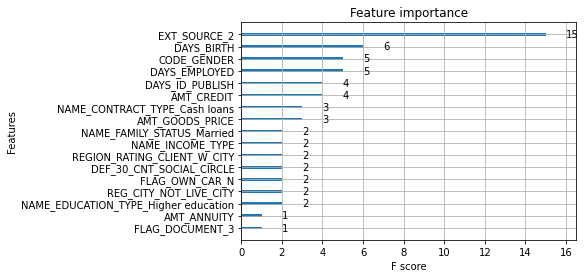

In [77]:
# 重要度の可視化

xgb.plot_importance(bst)

In [78]:
roc_auc_score(y_test, pred)

0.5032543237524608

**XGBoostで試したところ、精度は0.9208とロジスティック回帰とあまり変わらなかったが、roc_auc_scoreはかなり低かった。ただし、重要度の可視化の通り、どの特徴量が予測結果に寄与したのか見える化ができたため、これらの特徴量で再度ロジスティック回帰で回ってみる。**

In [98]:
#重要度上位の特徴量を選択

X = X2[["EXT_SOURCE_2","DAYS_BIRTH", "CODE_GENDER", "DAYS_EMPLOYED", "DAYS_ID_PUBLISH", "AMT_CREDIT"]]
X

,EXT_SOURCE_2,DAYS_BIRTH,CODE_GENDER,DAYS_EMPLOYED,DAYS_ID_PUBLISH,AMT_CREDIT
0,0.262949,-9461,1,-637.0,-2120,406597.5
1,0.622246,-16765,0,-1188.0,-291,1293502.5
2,0.555912,-19046,1,-225.0,-2531,135000.0
3,0.650442,-19005,0,-3039.0,-2437,312682.5
4,0.322738,-19932,1,-3038.0,-3458,513000.0
...,...,...,...,...,...,...
307506,0.681632,-9327,1,-236.0,-1982,254700.0
307507,0.115992,-20775,0,-1213.0,-4090,269550.0
307508,0.535722,-14966,0,-7921.0,-5150,677664.0
307509,0.514163,-11961,0,-4786.0,-931,370107.0


In [94]:
y = df_train_dropped.loc[:, 'TARGET']
y

0         1
1         0
2         0
3         0
4         0
         ..
307506    0
307507    0
307508    0
307509    1
307510    0
Name: TARGET, Length: 307511, dtype: int64

In [95]:
# KFoldクラスでtrainデータをクロスバリデーションで分割
# ロジスティック回帰で学習
# ROC曲線下面積(AUC)で評価

scores_roc = []

kf = KFold(n_splits=4, shuffle=True, random_state=42)
for train_index, test_index in kf.split(X, y):
#     print("train_index: ", train_index, 'test_index: ', test_index)
    
    # 訓練データ、検証データに分割
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]    
    
    #ロジスティック回帰
    lr = LogisticRegression(random_state=0, class_weight='balanced') # インスタンス作成
    lr.fit(X_train, y_train) # 学習
    y_pred_lr = lr.predict_proba(X_test)[:, 1] # 予測
#     y_pred_lr
    
    # ROC AUC で評価
    score_roc = roc_auc_score(y_test, y_pred_lr)
    scores_roc.append(score_roc)
    print(scores_roc[-1])
    
print("ROC AUCスコアの平均: {}".format(np.mean(scores_roc)))

0.5466883261817437
0.5474404517989009
0.5520242531843724
0.5480456232135708
ROC AUCスコアの平均: 0.548549663594647


**考察：XGBoostモデルで得た重要度上位の特徴量を抽出し回したところ、ROC AUCスコアの平均は下がった結果となった。恐らくノイズが入ったりしている可能性があり、これからの学習を通じて真の重要特徴量の判別を行った上、特徴量積など特徴量をもっと増やして試してみたいと思っている。**

## 【問題5】最終的なモデルの選定
最終的にこれは良いというモデルを選び、推定した結果をKaggleに提出してスコアを確認してください。どういったアイデアを取り入れ、どの程度のスコアになったかを記載してください。

**今回の結果として、kaggleに提出した1回目のスコア0.58681より、微増の0.60881にとどまった。時間と知識・スキル不足の関係上、一旦打ち切りにした上で、以下のように得た知見をまとめてみた：**

**処理の流れ及びモデルの選定**
 - データの中身をチェックし、EDAで大枠を掴む
 - XGBoostモデルでひとまず処理してみて、スコア及び重要度の可視化
 - 欠損値、異常値、カテゴリー変数のワンホットエンコーディングなどの前処理
 - ロジスティック回帰で重要そうな特徴量でピックアップして回す（パラメーチューリングしたうえ、クロスバリデーションfold5にて）
 - さらに特徴量積など重要な特徴量を増やして、他の手法も試してみる（アンサンブル）
 
 
**反省点及び勉強の方向性**
 - データに対して、もっと研究して、中身を理解すること
 - 本で体系的な知識をインプットした上、Kaggleの練習などでデータの前処理・ノイズ除去・クリーニング、適切なモデルの選定、アンサンブルの実施などに慣れていきたい